# (一) 針對員工離職率(left)進行離職與否的預測

In [1]:
import os, math, io
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn import tree
from lime import lime_tabular

def load_all_csv():
    train_name = os.path.join("data", "HW2_hr-analytics_train.csv")
    test_name = os.path.join("data", "HW2_hr-analytics_test.csv")
    train_df = pd.read_csv(train_name)
    test_df = pd.read_csv(test_name)
    return train_df, test_df

def shuffle(x_chunk, y_chunk):
    buf = list()
    for x, y in zip(x_chunk, y_chunk):
       buf.append((x,y))
    random.shuffle(buf)

    x_chunk_out, y_chunk_out = list(), list()
    for x, y in buf:
        x_chunk_out.append(x)
        y_chunk_out.append(y)
    x_chunk_out = np.array(x_chunk_out, dtype=np.float32)
    y_chunk_out = np.array(y_chunk_out, dtype=np.int32)
    return x_chunk_out, y_chunk_out

def split(x_chunk, y_chunk, r=0.9):
    x_chunk, y_chunk = shuffle(x_chunk, y_chunk)
    size = round(len(y_chunk) * r) 
    train_x = x_chunk[:size]
    train_y = y_chunk[:size]
    test_x = x_chunk[size:]
    test_y = y_chunk[size:]
    return train_x, train_y, test_x, test_y 

def get_data_format(df):
    dformat = dict()
    for label in df.keys().values:
        dformat[label] = dict()
    for k, v in df.dtypes.items():
        dformat[k]["obj"] = v == object
    for k, v in df.max(axis=0).items():
        if not dformat[k]["obj"]:
            dformat[k]["max"] = v
    for label in df.keys().values:
        if dformat[label]["obj"]:
            tset = set()
            vmape = dict()
            for v in df[label].values:
                tset.add(v)
            tset = sorted(list(tset))
            for i, v in enumerate(tset):
                vmape[v] = i
            dformat[label]["map"] = vmape
            dformat[label]["size"] = len(tset)
    return dformat

def transfer_data(df, dformat):
    labels = df.keys().values
    x_chunk = list()
    y_chunk = list()
    features = list()
    targets = list()

    for label in labels:
        fmt = dformat[label]
        if label == "left":
            targets = ["not left", "left"]
        else:
            if fmt["obj"]:
                features.append(label)
            else:
                features.append(label)

    for index, row in df.iterrows():
        x = list()
        y = int(0)

        for label in labels:
            val = row[label]
            fmt = dformat[label]
            if label == "left":
                y = [0] * 2
                y[val] = 1
            else:
                if fmt["obj"]:
                    # sub = [0] * fmt["size"]
                    # sub[fmt["map"][val]] = 1
                    title = label
                    sub = [ (fmt["map"][val] + 1)/fmt["size"] ]
                else:
                    title = label
                    sub = [ val/fmt["max"]  ]
                x.extend(sub)
        x_chunk.append(x)
        y_chunk.append(y)
    x_chunk = np.array(x_chunk, dtype=np.float32)
    y_chunk = np.array(y_chunk, dtype=np.int32)
    return x_chunk, y_chunk, features, targets

### 載入訓練資、編碼並分割成序練集和測試集

In [2]:
train_df, test_df = load_all_csv()
dformat = get_data_format(train_df)
x_chunk, y_chunk, features, targets = transfer_data(train_df, dformat)
train_x, train_y, test_x, test_y = split(x_chunk, y_chunk, r=0.9)

### 以 Decision Tree 訓練之

In [3]:
train_x, train_y, test_x, test_y = split(x_chunk, y_chunk, r=0.9)
clf = tree.DecisionTreeClassifier()
clf.fit(train_x, train_y)

DecisionTreeClassifier()

### 用混淆矩陣驗證訓練節果

Accurate Rate 97.30 %


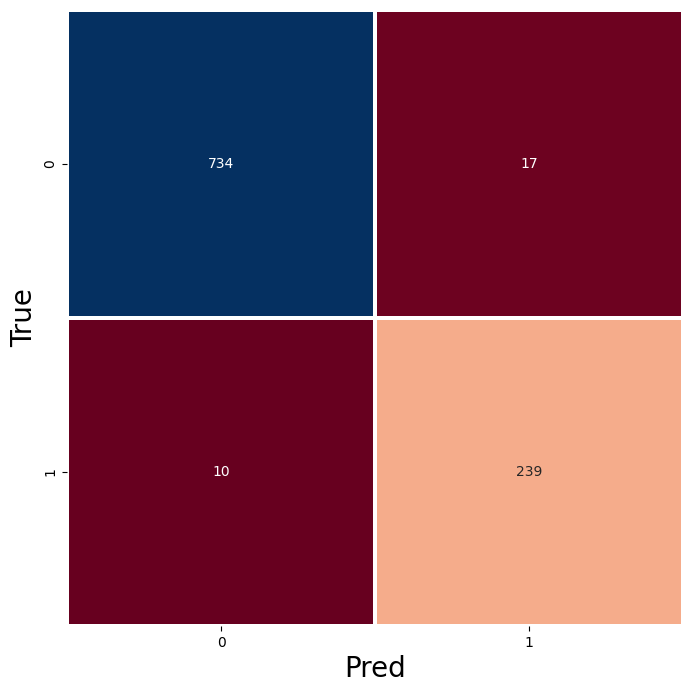

In [4]:
def test_performance(model, test_x, test_y):
    pred = model.predict(test_x)

    arg_p = np.argmax(pred, axis=-1)
    arg_y = np.argmax(test_y, axis=-1)

    cor = np.count_nonzero(arg_p == arg_y)
    cnt = len(arg_p)
    print("Accurate Rate {:.2f} %".format(100. * cor/cnt))

    table = confusion_matrix(arg_y, arg_p)

    plt.figure(figsize=(15,8))
    sns.heatmap(table,square=True,annot=True,fmt='d',linecolor='white',cmap='RdBu',linewidths=1.5,cbar=False)
    plt.xlabel('Pred',fontsize=20)
    plt.ylabel('True',fontsize=20)
    plt.show()

    # J = table[0][0]/(table[0][0] + table[0][1]) + table[1][1]/(table[1][0] + table[1][1]) - 1
    # print(J)

test_performance(clf, test_x, test_y)

### 找出兩個最佳的特徵數
輸出左側是挑選的特徵，右側此特徵對輸出結果影響力，影響力是所有測試集的平均影響力，使用 Lime 計算影響力

In [5]:
def find_top2(model, train_x, test_x, features, targets):
    def batch_predict(data):
        probs = model.predict(data)
        return probs

    explainer = lime_tabular.LimeTabularExplainer(
        training_data=train_x,
        feature_names=features,
        class_names=targets,
        mode="classification"
    )

    num_features = len(train_x[0])
    effect = [0] * num_features
    cnt = 0

    for x in test_x:
        exp = explainer.explain_instance(
            data_row=x,
            predict_fn=batch_predict,
            top_labels=2,
            num_features=num_features
        )
        for k, v in exp.as_list(label=1):
            for i, f in enumerate(features):
                if f in k:
                    effect[i] += abs(v)
                    break
        cnt += 1

    result = zip(features, np.array(effect)/cnt)
    result = sorted(list(result), key=lambda x: x[1], reverse=True)

    print("[Feature Name] -> [Effect Value]")
    for f, v in result[0:2]:
        print("{} -> {:.4f}".format(f, v))
find_top2(clf, train_x, test_x, features, targets)

[Feature Name] -> [Effect Value]
number_project -> 0.0522
satisfaction_level -> 0.0283


# 輸出預測結果

In [6]:
def print_results(model, x_chunk):
    pred_result = "left\n"
    pred = model.predict(x_chunk)

    for p in pred:
        pred_result += "{}\n".format(np.argmax(p))
    pred_result = pred_result[:-1]

    df = pd.read_csv(io.StringIO(pred_result), sep=",", header=None)
    print(df)

    df.to_csv("HW2_hr-analytics_test_sol.csv");

x_chunk, _, _, _ = transfer_data(test_df, dformat)
print_results(clf, x_chunk)

         0
0     left
1        0
2        0
3        1
4        1
...    ...
4996     0
4997     0
4998     0
4999     0
5000     1

[5001 rows x 1 columns]
